https://www.meteoblue.com/fr/meteo/archive/export?daterange=1985-01-01%20-%202023-07-31&locations%5B%5D=b%25c3%25a2le_suisse_2661604&domain=NEMSAUTO&params%5B%5D=&params%5B%5D=temp2m&params%5B%5D=&params%5B%5D=&params%5B%5D=&params%5B%5D=&params%5B%5D=&params%5B%5D=&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, validation_curve, KFold, GridSearchCV
from tqdm.notebook import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from neuralprophet import NeuralProphet

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
#Importation des données
temp = pd.read_csv('data1985.csv')
#temp.dropna(axis=0, inplace=True)
donnee = temp.iloc[:9]
temp = temp.iloc[9:]

temp

WARNING - (py.warnings._showwarnmsg) - c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)



,location,Bâle
9,19850101T0000,-3.2949712
10,19850101T0100,-3.2749712
11,19850101T0200,0.35502875
12,19850101T0300,0.36502874
13,19850101T0400,0.4150288
...,...,...
338188,20230731T1900,22.025028
338189,20230731T2000,21.875029
338190,20230731T2100,19.835028
338191,20230731T2200,18.755028


In [3]:
#Separer la date de l'heure
temp[['date', 'heure']] = temp['location'].str.rsplit("T", n=1, expand=True)
temp.drop(['location'], axis=1, inplace=True)

# Convertir la colonne de dates en objets de date et d'heure
temp['date'] = pd.to_datetime(temp['date'], format='%Y%m%d')
temp['heure'] = pd.to_datetime(temp['heure'], format='%H%M').dt.time

#Date to index
temp.set_index('date', inplace=True)

temp

,Bâle,heure
date,,
1985-01-01,-3.2949712,00:00:00
1985-01-01,-3.2749712,01:00:00
1985-01-01,0.35502875,02:00:00
1985-01-01,0.36502874,03:00:00
1985-01-01,0.4150288,04:00:00
...,...,...
2023-07-31,22.025028,19:00:00
2023-07-31,21.875029,20:00:00
2023-07-31,19.835028,21:00:00


In [4]:
temp.shape

(338184, 2)

In [5]:
#Verifier le type des données
temp.dtypes

Bâle     object
heure    object
dtype: object

In [6]:
#Str to numeric values
temp['Bâle'] = pd.to_numeric(temp['Bâle'], errors='coerce')

temp.dtypes

Bâle     float64
heure     object
dtype: object

In [7]:
#Remplir les veleurs manquantes par des valeurs de la ligne precedente
temp.ffill()

,Bâle,heure
date,,
1985-01-01,-3.294971,00:00:00
1985-01-01,-3.274971,01:00:00
1985-01-01,0.355029,02:00:00
1985-01-01,0.365029,03:00:00
1985-01-01,0.415029,04:00:00
...,...,...
2023-07-31,22.025028,19:00:00
2023-07-31,21.875029,20:00:00
2023-07-31,19.835028,21:00:00


In [8]:
#Extraction des veleurs significatives
temperature = temp.groupby(['date'])['Bâle'].agg(['max', 'min', 'mean'])

temperature

,max,min,mean
date,,,
1985-01-01,0.645029,-3.294971,-0.327888
1985-01-02,0.645029,-1.404971,-0.093305
1985-01-03,-1.444971,-3.444971,-2.441638
1985-01-04,-0.954971,-14.424971,-5.059138
1985-01-05,-8.394971,-17.884972,-12.670805
...,...,...,...
2023-07-27,26.305029,8.185029,17.651695
2023-07-28,26.845028,11.365029,19.691278
2023-07-29,21.785028,16.225029,19.505862


In [9]:
#Verifier le type des index
temperature.index

DatetimeIndex(['1985-01-01', '1985-01-02', '1985-01-03', '1985-01-04',
               '1985-01-05', '1985-01-06', '1985-01-07', '1985-01-08',
               '1985-01-09', '1985-01-10',
               ...
               '2023-07-22', '2023-07-23', '2023-07-24', '2023-07-25',
               '2023-07-26', '2023-07-27', '2023-07-28', '2023-07-29',
               '2023-07-30', '2023-07-31'],
              dtype='datetime64[ns]', name='date', length=14091, freq=None)

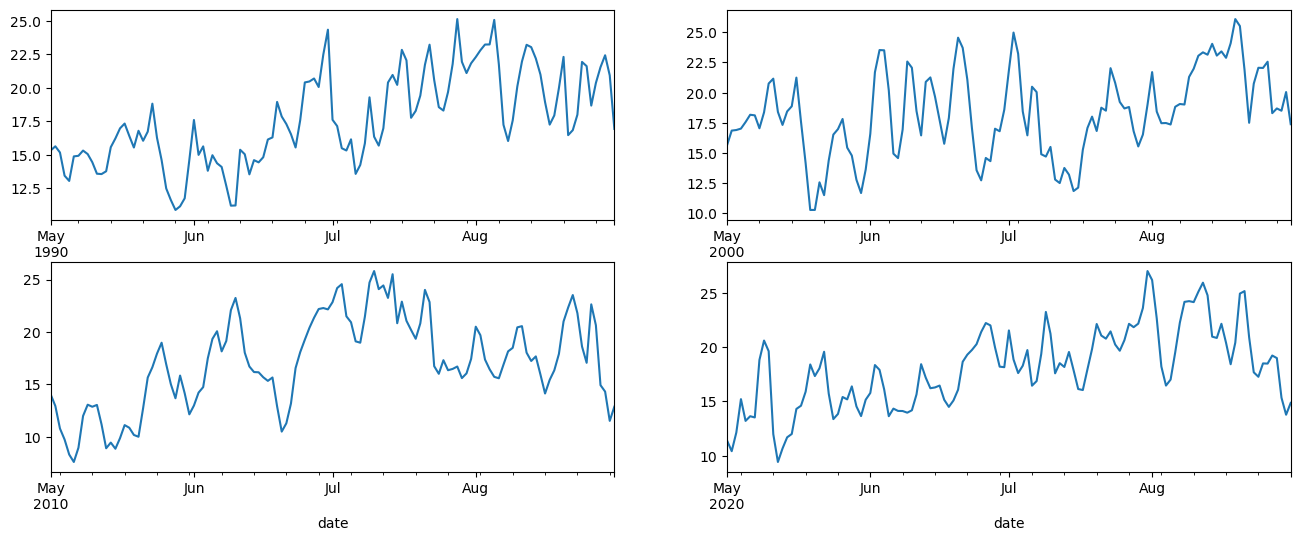

In [10]:
plt.figure(figsize=(16,6))
plt.subplot(2,2,1)
temperature['1990-05':'1990-08']['mean'].plot()
plt.subplot(2,2,2)
temperature['2000-05':'2000-08']['mean'].plot()
plt.subplot(2,2,3)
temperature['2010-05':'2010-08']['mean'].plot()
plt.subplot(2,2,4)
temperature['2020-05':'2020-08']['mean'].plot()
plt.show()

In [11]:
temperature.index.year.value_counts().sort_index()

1985    365
1986    365
1987    365
1988    366
1989    365
1990    365
1991    365
1992    366
1993    365
1994    365
1995    365
1996    366
1997    365
1998    365
1999    365
2000    366
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    212
Name: date, dtype: int64

In [12]:
#Valeur à predire : valeurCible n'est que la colonne mean décalé par un jour avant
temperature['valeurCible'] = temperature.shift(-1)['mean']

temperature

,max,min,mean,valeurCible
date,,,,
1985-01-01,0.645029,-3.294971,-0.327888,-0.093305
1985-01-02,0.645029,-1.404971,-0.093305,-2.441638
1985-01-03,-1.444971,-3.444971,-2.441638,-5.059138
1985-01-04,-0.954971,-14.424971,-5.059138,-12.670805
1985-01-05,-8.394971,-17.884972,-12.670805,-9.969554
...,...,...,...,...
2023-07-27,26.305029,8.185029,17.651695,19.691278
2023-07-28,26.845028,11.365029,19.691278,19.505862
2023-07-29,21.785028,16.225029,19.505862,18.963778


In [13]:
#Remplir les veleurs manquantes par des valeurs de la ligne precedente
#Particulièrement pour la dérnière ligne

temperature = temperature.ffill()
temperature

,max,min,mean,valeurCible
date,,,,
1985-01-01,0.645029,-3.294971,-0.327888,-0.093305
1985-01-02,0.645029,-1.404971,-0.093305,-2.441638
1985-01-03,-1.444971,-3.444971,-2.441638,-5.059138
1985-01-04,-0.954971,-14.424971,-5.059138,-12.670805
1985-01-05,-8.394971,-17.884972,-12.670805,-9.969554
...,...,...,...,...
2023-07-27,26.305029,8.185029,17.651695,19.691278
2023-07-28,26.845028,11.365029,19.691278,19.505862
2023-07-29,21.785028,16.225029,19.505862,18.963778


In [14]:
#J'ai enlevé le mois 1 et 2 de 1985 et le mois 6 et 7 de 2023 car ils designe in demi-saison et cela peut perturber notre data lors 
#de l'entrainement
temperature = temperature['1985-03':'2023-05']
temperature['mois'] = temperature.index.month
temperature

WARNING - (py.warnings._showwarnmsg) - C:\Users\PC de MEDUSA\AppData\Local\Temp\ipykernel_53176\627186540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature['mois'] = temperature.index.month



,max,min,mean,valeurCible,mois
date,,,,,
1985-03-01,14.145029,1.775029,7.934196,6.387945,3
1985-03-02,8.945029,2.315029,6.387945,5.099196,3
1985-03-03,9.585029,0.145029,5.099196,6.802112,3
1985-03-04,9.475029,4.845029,6.802112,6.136279,3
1985-03-05,8.355029,4.635029,6.136279,6.357112,3
...,...,...,...,...,...
2023-05-27,24.145027,11.665029,18.363362,18.094195,5
2023-05-28,24.525028,10.785029,18.094195,18.206278,5
2023-05-29,25.065027,10.255029,18.206278,16.735862,5


In [15]:
automne = temperature[ temperature['mois'].isin([9, 10, 11]) ].drop(['mois'], axis=1)
hiver = temperature[ temperature['mois'].isin([12, 1, 2]) ].drop(['mois'], axis=1)
printemps = temperature[ temperature['mois'].isin([3, 4, 5]) ].drop(['mois'], axis=1)
ete = temperature[ temperature['mois'].isin([6, 7, 8]) ].drop(['mois'], axis=1)

In [16]:
automne

,max,min,mean,valeurCible
date,,,,
1985-09-01,21.525028,13.925029,18.907112,17.075445
1985-09-02,24.145027,10.185029,17.075445,15.177529
1985-09-03,17.815027,12.605029,15.177529,14.090029
1985-09-04,15.995029,12.035029,14.090029,15.940445
1985-09-05,20.405027,11.325029,15.940445,13.880029
...,...,...,...,...
2022-11-26,9.625029,3.705029,7.293779,5.123362
2022-11-27,11.195029,-0.274971,5.123362,7.955862
2022-11-28,11.165029,4.915029,7.955862,8.223779


In [17]:
automne.corr()

,max,min,mean,valeurCible
max,1.000000,0.744300,0.946470,0.915097
min,0.744300,1.000000,0.906938,0.801591
mean,0.946470,0.906938,1.000000,0.928738
valeurCible,0.915097,0.801591,0.928738,1.000000


We're going to apply a ridge regression model which works very similarly to linear regression except it penalizes coefficients to account for multi-collinearity.

So the reason I didn't account if you're using a regular linear regression you'd have to worry about it a little bit more

Typically when you try to estimate the error of a machine learning model you can use cross-validation except with time series data.

With time series data we need to be really careful not to use future data to predict the past,
So we need to actually use a special technique called back testing and finance or time series cross-validation to account for the time series nature of the data.

# 1ere methode : Ridge-Lasso

In [21]:
model_1 = Ridge(alpha=0.1)
model_2 = Lasso(alpha=0.1, selection='cyclic')

In [22]:
col_entrainement = temperature.columns[temperature.columns.isin(['max', 'min', 'mean'])]
col_entrainement

Index(['max', 'min', 'mean'], dtype='object')

In [23]:
automne_entrainement = automne[:'2017-11']
automne_test = automne['2018-09':]
automne_entrainement

,max,min,mean,valeurCible
date,,,,
1985-09-01,21.525028,13.925029,18.907112,17.075445
1985-09-02,24.145027,10.185029,17.075445,15.177529
1985-09-03,17.815027,12.605029,15.177529,14.090029
1985-09-04,15.995029,12.035029,14.090029,15.940445
1985-09-05,20.405027,11.325029,15.940445,13.880029
...,...,...,...,...
2017-11-26,4.165029,0.655029,2.848779,3.610029
2017-11-27,6.955029,-0.584971,3.610029,4.509195
2017-11-28,6.225029,2.935029,4.509195,3.489612


In [24]:
hiver_entrainement = hiver[:'2018-02']
hiver_test = hiver['2018-12':]
hiver_entrainement

,max,min,mean,valeurCible
date,,,,
1985-12-01,11.815029,1.885029,5.528362,6.575862
1985-12-02,13.835029,2.235029,6.575862,8.248362
1985-12-03,15.875029,2.445029,8.248362,9.137112
1985-12-04,16.105028,3.325029,9.137112,7.299612
1985-12-05,14.025029,1.815029,7.299612,7.687112
...,...,...,...,...
2018-02-24,3.705029,-3.274971,-0.519971,-4.072888
2018-02-25,-0.164971,-6.804971,-4.072888,-6.612888
2018-02-26,-4.224971,-8.214971,-6.612888,-6.318721


In [25]:
printemps_entrainement = printemps[:'2018-05']
printemps_test = printemps['2019-03':]
printemps_entrainement

,max,min,mean,valeurCible
date,,,,
1985-03-01,14.145029,1.775029,7.934196,6.387945
1985-03-02,8.945029,2.315029,6.387945,5.099196
1985-03-03,9.585029,0.145029,5.099196,6.802112
1985-03-04,9.475029,4.845029,6.802112,6.136279
1985-03-05,8.355029,4.635029,6.136279,6.357112
...,...,...,...,...
2018-05-27,28.915028,16.465029,22.830862,21.106278
2018-05-28,27.055029,15.795029,21.106278,19.249195
2018-05-29,24.995028,13.015029,19.249195,20.354612


In [26]:
ete_entrainement = ete[:'2017-08']
ete_test = ete['2018-06':]
ete_entrainement

,max,min,mean,valeurCible
date,,,,
1985-06-01,21.325027,7.905028,14.616695,14.574195
1985-06-02,19.295029,10.155029,14.574195,14.840029
1985-06-03,22.155027,8.055029,14.840029,17.025028
1985-06-04,27.035028,8.755029,17.025028,16.765445
1985-06-05,23.105028,9.895029,16.765445,17.740029
...,...,...,...,...
2017-08-27,31.125029,16.295029,24.844612,24.724611
2017-08-28,30.065027,19.525028,24.724611,23.187528
2017-08-29,30.645027,15.475029,23.187528,23.111695


ce qui reste à faire :
    
    *découper les données en train_set et test_set (DONE)
    
    *utilisier validation_cross avec KFold et cv equivalent au 90 jrs d'une saison

In [27]:
l = np.logspace(-5, 5, 11)
k = np.linspace(0.1, 0.9, 9)
Cv = KFold(33)

In [28]:
cross_val_score(model_1, hiver_entrainement[col_entrainement], hiver_entrainement['valeurCible'], cv=Cv, scoring='r2')

array([0.80349616, 0.75938923, 0.64935168, 0.39164397, 0.68225921,
       0.79773103, 0.72330624, 0.74828698, 0.61047832, 0.7294475 ,
       0.61345021, 0.81673856, 0.79425524, 0.69457034, 0.66587218,
       0.64717127, 0.80411089, 0.81285905, 0.57104547, 0.71054403,
       0.59134325, 0.76083396, 0.73093647, 0.68793456, 0.71618039,
       0.67180706, 0.861025  , 0.67219383, 0.46632617, 0.63472857,
       0.52862973, 0.79616824, 0.72821033])

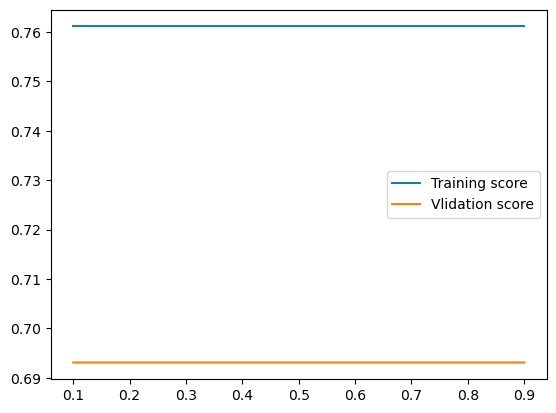

In [29]:
train_score, val_score = validation_curve(model_1, hiver_entrainement[col_entrainement], hiver_entrainement['valeurCible'], param_name='alpha', param_range=k, cv=Cv, scoring='r2')

plt.plot(k, train_score.mean(axis=1), label='Training score')
plt.plot(k, val_score.mean(axis=1), label='Vlidation score')
plt.legend()
plt.show()

In [30]:
param_grid = {'alpha': np.linspace(0.1, 0.9, 9)}
#'metric': ['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol']
grid = GridSearchCV(model_2, param_grid, cv=Cv)
grid.fit(hiver_entrainement[col_entrainement], hiver_entrainement['valeurCible'])

GridSearchCV(cv=KFold(n_splits=33, random_state=None, shuffle=False),
             estimator=Lasso(alpha=0.1),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [31]:
grid.best_score_

0.6930315982548547

In [32]:
saison = hiver_entrainement
i = 2001

k_ent = str(i+1)+'-02'
k_val = str(i+1)+'-12'
kk_val = str(i+2)+'-02'
#k_test = str(i+2)+'-09'
#kk_test = str(i+3)+'-11'

entrainement = saison[:k_ent]
validation = saison[k_val:kk_val]
#test = saison[k_test:kk_test]

In [33]:
entrainement

,max,min,mean,valeurCible
date,,,,
1985-12-01,11.815029,1.885029,5.528362,6.575862
1985-12-02,13.835029,2.235029,6.575862,8.248362
1985-12-03,15.875029,2.445029,8.248362,9.137112
1985-12-04,16.105028,3.325029,9.137112,7.299612
1985-12-05,14.025029,1.815029,7.299612,7.687112
...,...,...,...,...
2002-02-24,4.795029,0.765029,2.790029,5.077112
2002-02-25,8.815029,1.785029,5.077112,8.443779
2002-02-26,12.435029,4.755029,8.443779,9.624612


In [34]:
validation

,max,min,mean,valeurCible
date,,,,
2002-12-01,7.915029,4.745029,6.008362,5.871279
2002-12-02,7.355029,4.775029,5.871279,6.011279
2002-12-03,8.955029,4.295029,6.011279,4.769612
2002-12-04,6.305029,3.375029,4.769612,3.818779
2002-12-05,5.255029,1.465029,3.818779,2.610862
...,...,...,...,...
2003-02-24,10.485029,-1.794971,3.870446,3.834612
2003-02-25,10.795029,-2.474971,3.834612,6.535446
2003-02-26,13.805029,0.295029,6.535446,6.887112


In [35]:
model_1.fit(entrainement[col_entrainement], entrainement['valeurCible'])
preds = model_1.predict(validation[col_entrainement])

preds = pd.Series(preds, index=validation.index)
preds

date
2002-12-01    5.117912
2002-12-02    4.872801
2002-12-03    5.443475
2002-12-04    3.977579
2002-12-05    3.157067
                ...   
2003-02-24    4.809105
2003-02-25    4.885283
2003-02-26    7.213912
2003-02-27    7.779417
2003-02-28    8.225178
Length: 90, dtype: float64

In [36]:
resultats = pd.concat([validation['valeurCible'], preds], axis=1)
resultats

,valeurCible,0
date,,
2002-12-01,5.871279,5.117912
2002-12-02,6.011279,4.872801
2002-12-03,4.769612,5.443475
2002-12-04,3.818779,3.977579
2002-12-05,2.610862,3.157067
...,...,...
2003-02-24,3.834612,4.809105
2003-02-25,6.535446,4.885283
2003-02-26,6.887112,7.213912


In [37]:
resultats.columns = ['actuel', 'prediction']
resultats

,actuel,prediction
date,,
2002-12-01,5.871279,5.117912
2002-12-02,6.011279,4.872801
2002-12-03,4.769612,5.443475
2002-12-04,3.818779,3.977579
2002-12-05,2.610862,3.157067
...,...,...
2003-02-24,3.834612,4.809105
2003-02-25,6.535446,4.885283
2003-02-26,6.887112,7.213912


In [38]:
resultats['diff'] = (resultats['prediction'] - resultats['actuel']).abs()
resultats

,actuel,prediction,diff
date,,,
2002-12-01,5.871279,5.117912,0.753367
2002-12-02,6.011279,4.872801,1.138478
2002-12-03,4.769612,5.443475,0.673863
2002-12-04,3.818779,3.977579,0.158800
2002-12-05,2.610862,3.157067,0.546205
...,...,...,...
2003-02-24,3.834612,4.809105,0.974493
2003-02-25,6.535446,4.885283,1.650162
2003-02-26,6.887112,7.213912,0.326799


In [39]:
resultats['prediction'] = resultats.shift(-1)['prediction']
resultats

,actuel,prediction,diff
date,,,
2002-12-01,5.871279,4.872801,0.753367
2002-12-02,6.011279,5.443475,1.138478
2002-12-03,4.769612,3.977579,0.673863
2002-12-04,3.818779,3.157067,0.158800
2002-12-05,2.610862,2.531642,0.546205
...,...,...,...
2003-02-24,3.834612,4.885283,0.974493
2003-02-25,6.535446,7.213912,1.650162
2003-02-26,6.887112,7.779417,0.326799


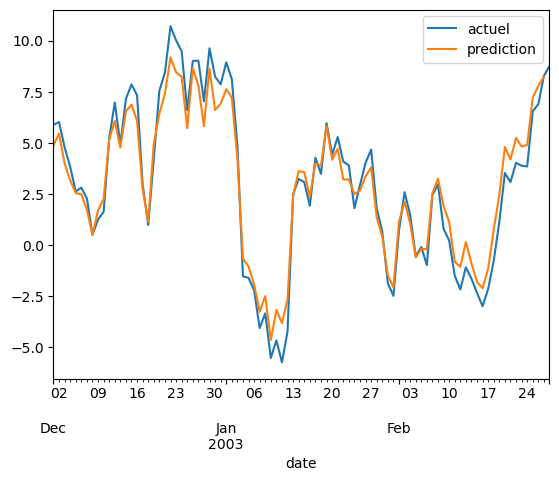

In [40]:

resultats['actuel'].plot(label='actuel')
resultats['prediction'].plot(label='prediction')
plt.legend()
plt.show()

In [41]:
def backtest(model, saison, col_entr):
    #predictions = []
    
    for i in range(1985, 2015):
        
        if ((saison.equals(hiver_entrainement)) or (saison.equals(hiver))):#2015
            k_ent = str(i+1)+'-02'
            k_val = str(i+1)+'-12'
            kk_val = str(i+2)+'-02'
            k_test = str(i+2)+'-09'
            kk_test = str(i+3)+'-11'
        elif ((saison.equals(automne_entrainement)) or (saison.equals(automne))):#2015
            k_ent = str(i)+'-11'
            k_val = str(i+1)+'-09'
            kk_val = str(i+1)+'-11'
            k_test = str(i+2)+'-09'
            kk_test = str(i+2)+'-11'
        elif ((saison.equals(printemps_entrainement)) or (saison.equals(printemps))):#2016
            k_ent = str(i)+'-05'
            k_val = str(i+1)+'-03'
            kk_val = str(i+1)+'-05'
            k_test = str(i+2)+'-03'
            kk_test = str(i+2)+'-05'
        elif ((saison.equals(ete_entrainement)) or (saison.equals(ete))):#2015
            k_ent = str(i)+'-08'
            k_val = str(i+1)+'-06'
            kk_val = str(i+1)+'-08'
            k_test = str(i+2)+'-06'
            kk_test = str(i+2)+'-08'
        
        entrainement = saison[:k_ent]
        validation = saison[k_val:kk_val]
        test = saison[k_test:kk_test]
        
        model.fit(entrainement[col_entr], validation['valeurCible'])
        preds = model.predict(test[col_entr])

        preds = pd.Series(preds, index=test.index)
        resultats = pd.concat([test['valeurCible'], preds], axis=1)
        resultats.columns = ['actuel', 'prediction']
        resultats['diff'] = (resultats['prediction'] - resultats['actuel']).abs()
        
        #predictions.append(resultats)
    return resultats

In [42]:
def backtest_2(weather, model, predictors, start=0, step=90):
    all_predictions = []
    
    for i in range(start, weather.shape[0]-8, step):
        weather = weather[:weather.shape[0]-8]
        train = weather.iloc[i:(i+step),:]
        val = weather.iloc[(i+step):(i+(2*step)),:]
        test = weather.iloc[(i+(2*step)):(i+(3*step)),:]
        
        model.fit(train[predictors], val["valeurCible"])
        preds = model.predict(test[predictors])
        
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["valeurCible"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [43]:
backtest_2(hiver_entrainement, model_1, col_entrainement)

ValueError: Found input variables with inconsistent numbers of samples: [90, 38]

# 2eme methode : SARIMAX

In [44]:
temperature.columns

Index(['max', 'min', 'mean', 'valeurCible', 'mois'], dtype='object')

In [45]:
temperature.shape

(13971, 5)

In [46]:
N = temperature.shape[0]
split = 0.90
training_size = round(split*N)
test_size = round((1-split)*N)

training = temperature['mean'][:training_size]
test = temperature['mean'][training_size:N]

In [47]:
def optimize_ARIMA(order_list, exog):
    results = []
    
    for order in tqdm_notebook(order_list):
        model = SARIMAX(exog, order=order).fit(disp=-1)

        aic = model.aic
        results.append([order, model.aic])
    
    #print(results)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [48]:
# d = 0
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

In [49]:
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
parameters_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (7, 8),
 (7, 9),
 (8, 0),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8),
 (8, 9),
 (9, 0),
 (9, 1),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 9)]

In [50]:
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)

order_list

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 0, 6),
 (1, 0, 7),
 (1, 0, 8),
 (1, 0, 9),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 0, 5),
 (2, 0, 6),
 (2, 0, 7),
 (2, 0, 8),
 (2, 0, 9),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 0, 5),
 (3, 0, 6),
 (3, 0, 7),
 (3, 0, 8),
 (3, 0, 9),
 (4, 0, 0),
 (4, 0, 1),
 (4, 0, 2),
 (4, 0, 3),
 (4, 0, 4),
 (4, 0, 5),
 (4, 0, 6),
 (4, 0, 7),
 (4, 0, 8),
 (4, 0, 9),
 (5, 0, 0),
 (5, 0, 1),
 (5, 0, 2),
 (5, 0, 3),
 (5, 0, 4),
 (5, 0, 5),
 (5, 0, 6),
 (5, 0, 7),
 (5, 0, 8),
 (5, 0, 9),
 (6, 0, 0),
 (6, 0, 1),
 (6, 0, 2),
 (6, 0, 3),
 (6, 0, 4),
 (6, 0, 5),
 (6, 0, 6),
 (6, 0, 7),
 (6, 0, 8),
 (6, 0, 9),
 (7, 0, 0),
 (7, 0, 1),
 (7, 0, 2),
 (7, 0, 3),
 (7, 0, 4),
 (7, 0, 5),
 (7, 0, 6),
 (7, 0, 7),
 (7, 0, 8),
 (7, 0, 9),
 (8, 0, 0),
 (8, 0, 1),
 (8, 0, 2),
 (8,

In [51]:
result_d_0 = optimize_ARIMA(order_list, exog = training)

result_d_0

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency informa

KeyboardInterrupt: 

In [ ]:
# d = 1
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_1 = optimize_ARIMA(order_list, exog = training)

result_d_1

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferre

,"(p, d, q)",AIC
0,"(9, 1, 9)",51593.076687
1,"(7, 1, 9)",51606.036111
2,"(9, 1, 5)",51623.100890
3,"(8, 1, 9)",51642.150830
4,"(1, 1, 3)",51643.197521
...,...,...
95,"(0, 1, 2)",52307.078873
96,"(1, 1, 1)",52571.605374
97,"(0, 1, 1)",52716.048054
98,"(1, 1, 0)",52860.943781


# Moyenne sur les mois

<AxesSubplot: xlabel='date'>

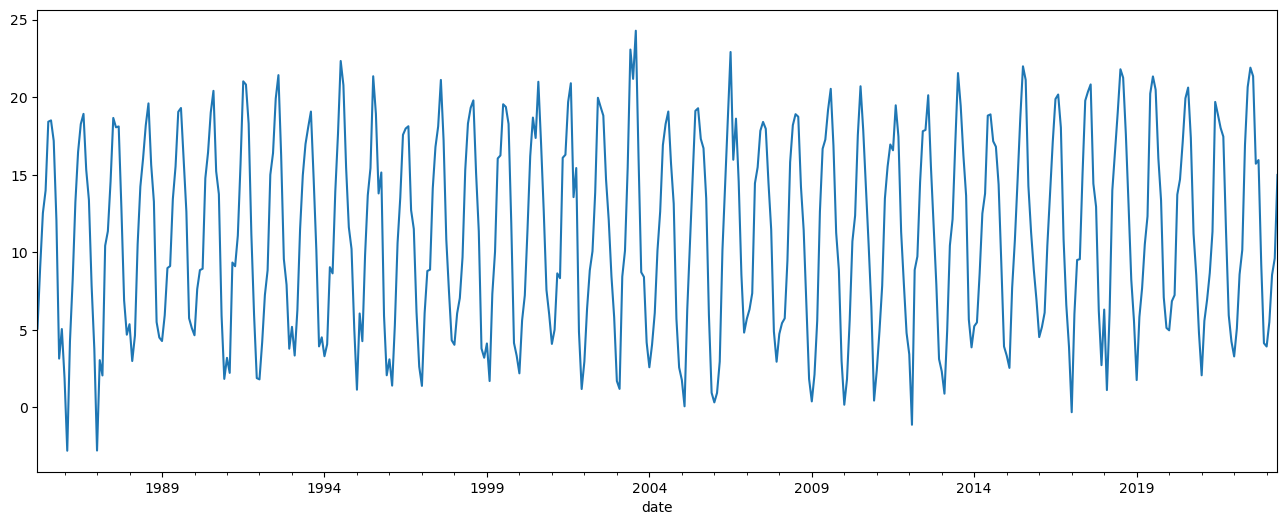

In [ ]:
moy_par_mois = temperature["mean"].resample('M').mean()
plt.figure(figsize=(16,6))
moy_par_mois.plot()

In [ ]:
moy_par_mois.shape[0]

459

In [ ]:
N = moy_par_mois.shape[0]
split = 0.90
training_size = round(split*N)
test_size = round((1-split)*N)

last_training = moy_par_mois[:training_size]
last_test = moy_par_mois[training_size:N]

In [ ]:
# d = 0 / new dataset
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_00 = optimize_ARIMA(order_list, exog = last_training)

result_d_00

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC de MEDUSA\anaconda3\lib\site-pack

LinAlgError: LU decomposition error.

In [ ]:
# d = 1 / new dataset
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_11 = optimize_ARIMA(order_list, exog = last_training)

result_d_11

In [ ]:
final_result = result_d_00.append(result_d_11)
best_models = final_result.sort_values(by='AIC', ascending=True).reset_index(drop=True).head()
best_models

C:\Users\PC de MEDUSA\AppData\Local\Temp\ipykernel_38988\1087737579.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = result_d_00.append(result_d_11)


,"(p, d, q)",AIC
0,"(9, 1, 4)",27292.570144
1,"(9, 1, 6)",27320.865600
2,"(7, 0, 3)",27328.709772
3,"(8, 1, 1)",27345.382837
4,"(1, 1, 3)",27345.743057


In [ ]:
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_params_1 = best_models[best_models.columns[0]][1]

In [ ]:
best_model_0 = SARIMAX(last_training, order=best_model_params_0).fit()
print(best_model_0.summary())
best_model_1 = SARIMAX(last_training, order=best_model_params_1).fit()
print(best_model_1.summary())

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   mean   No. Observations:                 6710
Model:               SARIMAX(9, 1, 4)   Log Likelihood              -13632.285
Date:                Thu, 17 Aug 2023   AIC                          27292.570
Time:                        19:49:33   BIC                          27387.927
Sample:                    01-01-2003   HQIC                         27325.499
                         - 05-15-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2698      2.058      0.131      0.896      -3.763       4.303
ar.L2          1.5019      2.458      0.611      0.541      -3.316       6.320
ar.L3         -0.4698      0.823     -0.571      0.5

c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC de MEDUSA\anaconda3\lib\site-packages\statsmodels\base\model.py:6

                               SARIMAX Results                                
Dep. Variable:                   mean   No. Observations:                 6710
Model:               SARIMAX(9, 1, 6)   Log Likelihood              -13644.433
Date:                Thu, 17 Aug 2023   AIC                          27320.866
Time:                        19:49:43   BIC                          27429.845
Sample:                    01-01-2003   HQIC                         27358.498
                         - 05-15-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0777      1.243      0.063      0.950      -2.359       2.514
ar.L2          1.4206      0.524      2.711      0.007       0.393       2.448
ar.L3          0.3493      1.481      0.236      0.8

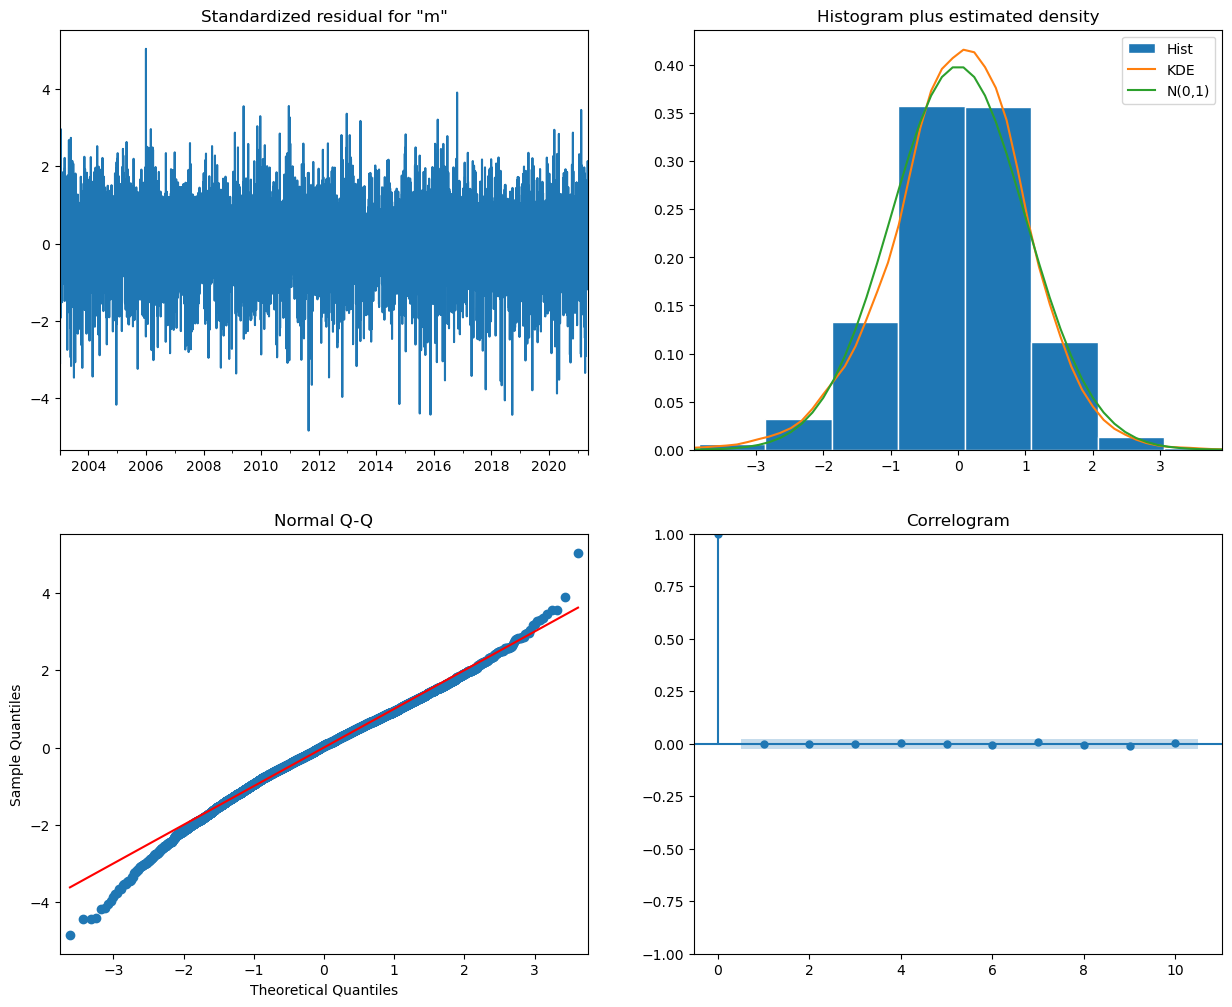

In [ ]:
best_model_0.plot_diagnostics(figsize=(15,12))
plt.show()

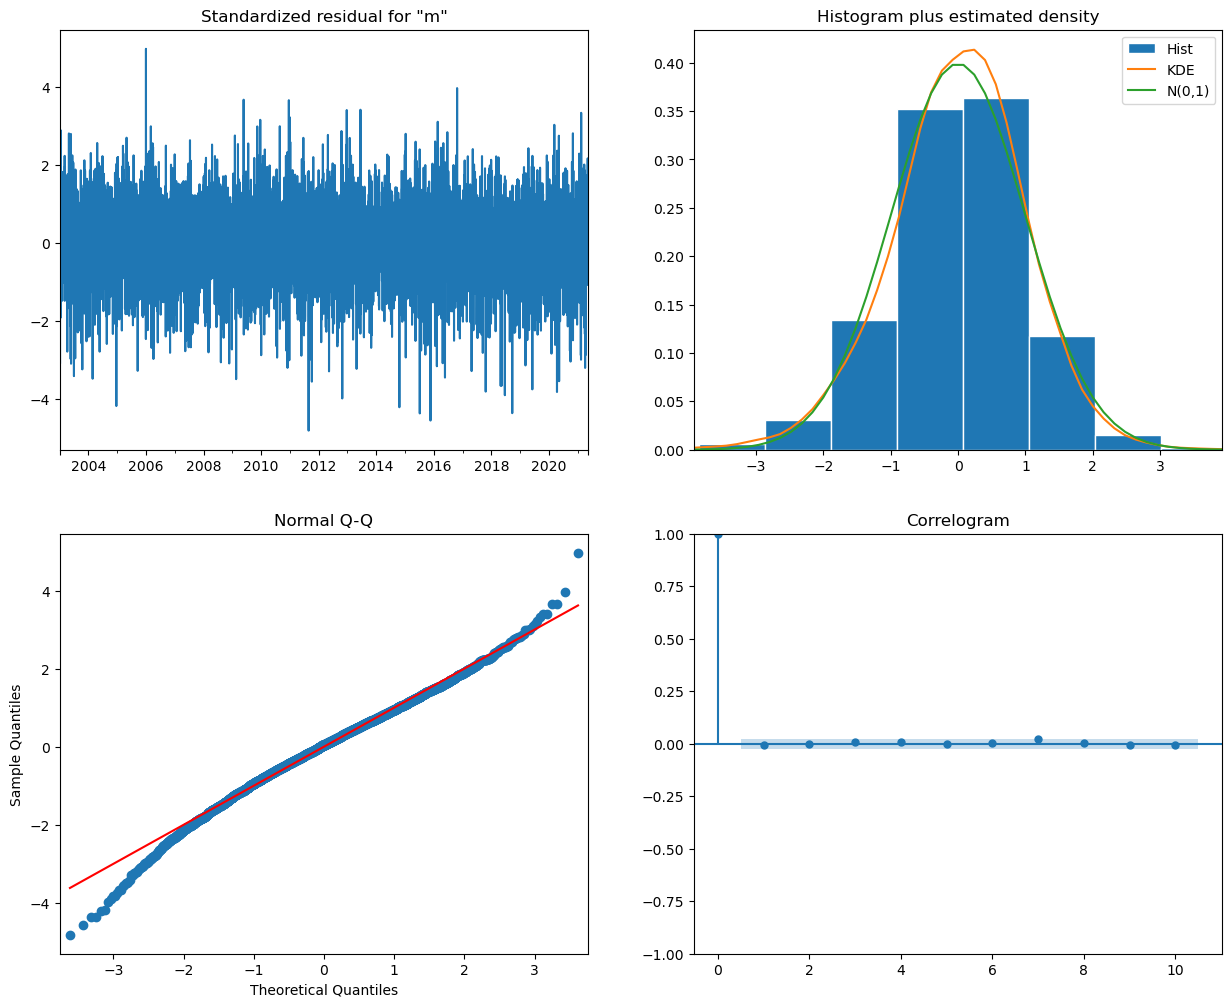

In [ ]:
best_model_1.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
forecast = best_model_0.get_prediction(start=training_size, end=training_size+test_size)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

<AxesSubplot: >

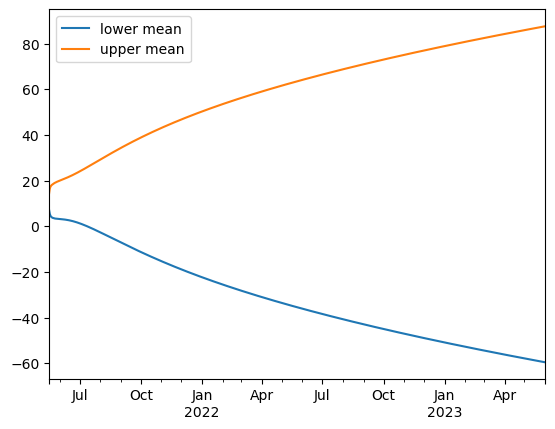

In [ ]:
ci.plot()

In [ ]:
s_forecast = best_model_1.get_prediction(start=training_size, end=training_size+test_size)
s_forec = s_forecast.predicted_mean
s_ci = forecast.conf_int(alpha=0.05)

<AxesSubplot: xlabel='date'>

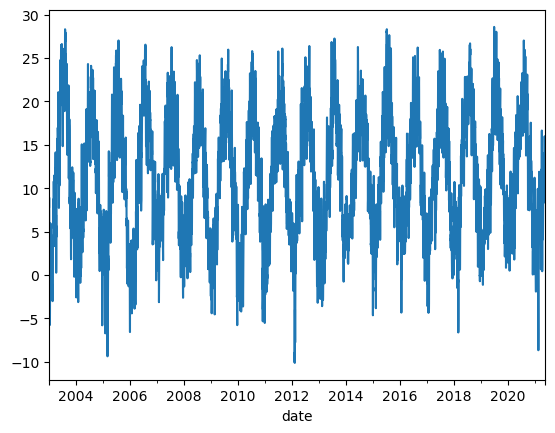

In [ ]:
last_training.plot()

In [ ]:
#last_training[training_size:training_size+test_size]
last_training.index

DatetimeIndex(['2003-01-01', '2003-01-02', '2003-01-03', '2003-01-04',
               '2003-01-05', '2003-01-06', '2003-01-07', '2003-01-08',
               '2003-01-09', '2003-01-10',
               ...
               '2021-05-06', '2021-05-07', '2021-05-08', '2021-05-09',
               '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13',
               '2021-05-14', '2021-05-15'],
              dtype='datetime64[ns]', name='date', length=6710, freq=None)

In [ ]:
pd.DataFrame(forec, columns=['f'], index = x1)

,f
date,
2003-01-01,NaN
2003-01-02,NaN
2003-01-03,NaN
2003-01-04,NaN
2003-01-05,NaN
...,...
2021-05-11,NaN
2021-05-12,NaN
2021-05-13,NaN


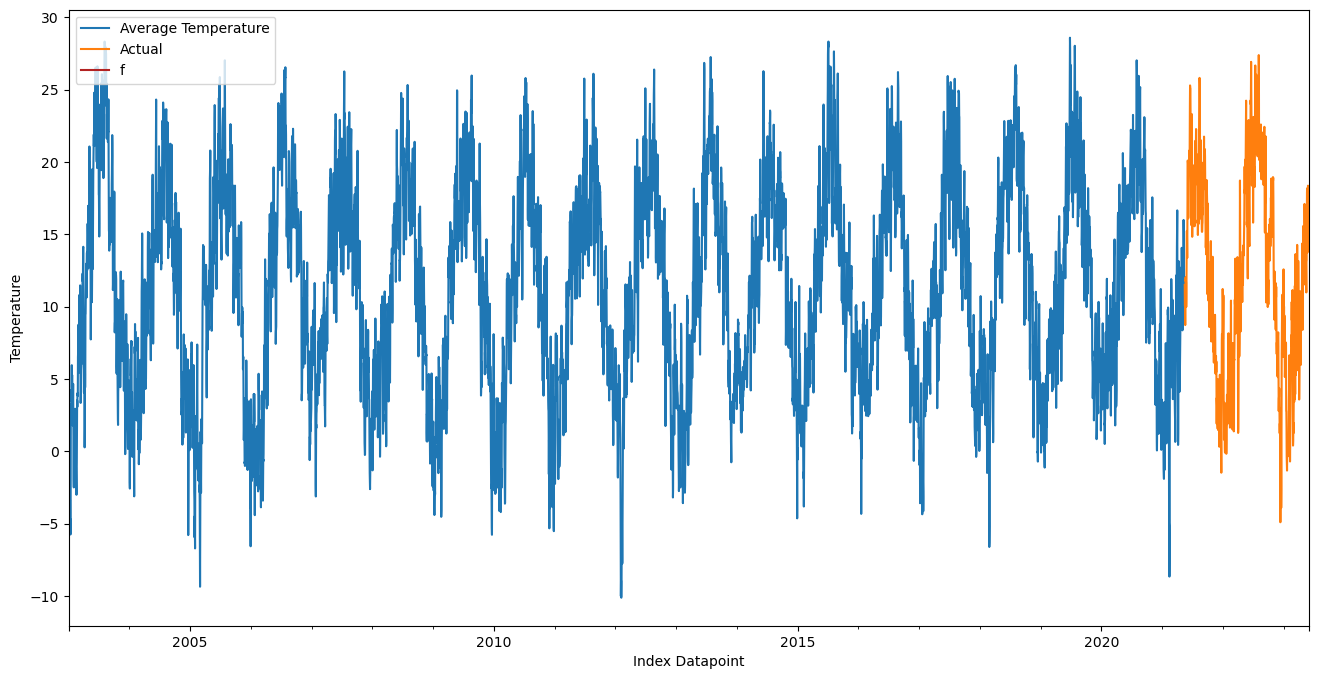

In [ ]:
#error_test=chicago_data.loc[test_date[1:].index.tolist()].AverageTemperatureUncertainty
#index_test = test_date[1:].index.tolist()
#test_set = test_series[1:]
#lower_test = test_set-error_test
#upper_test = test_set+error_test
fig, ax = plt.subplots(figsize=(16,8))
#x0 = chicago_data.AverageTemperature.index[0:training_size]
x1 = last_training.index
#ax.fill_between(forec, ci['lower Load'], ci['upper Load'])
#plt.plot(x0, chicago_data.AverageTemperature[0:training_size],'k', label = 'Average Temperature')
last_training.plot(label = 'Average Temperature')

#plt.plot(chicago_data.AverageTemperature[training_size:training_size+fore_l], '.k', label = 'Actual')
last_test.plot(label = 'Actual')

#forec = pd.DataFrame(forec, columns=['f'], index = x1)
#forec.f.plot(ax=ax,color = 'Darkorange',label = 'Forecast (9, 1, 4) model')
#ax.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

s_forec = pd.DataFrame(s_forec, columns=['f'], index = x1)
s_forec.plot(ax=ax,color = 'firebrick',label = 'Forecast  (9, 1, 6) model')
#ax.fill_between(x1, s_ci['lower AverageTemperature'], s_ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')


plt.legend(loc = 'upper left')
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()